In [1]:
pip install openai python-dotenv youtube-transcript-api "langchain>=0.2.0"

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
from youtube_transcript_api import YouTubeTranscriptApi
from urllib.parse import urlparse, parse_qs
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, END
from langchain_core.messages import SystemMessage, HumanMessage
from typing import TypedDict, List, Union
from langchain_core.messages import AnyMessage

In [3]:
from dotenv import load_dotenv
load_dotenv()

True

In [4]:
MAX_TRANSCRIPT_CHARS = 100000
llm = ChatOpenAI(model="gpt-4o-mini", streaming=True)

In [5]:
class AgentState(TypedDict):
    messages: List[Union[dict, AnyMessage]]
    transcript: str
    summary: str

In [6]:
def get_script_node(state: AgentState) -> dict:
    """유튜브 URL에서 자막을 추출하고 상태에 저장합니다."""
    print("1. 자막 추출")
    last_message = state["messages"][-1]
    video_url = last_message['content'] if isinstance(last_message, dict) else last_message.content

    video_id = None
    try:
        parsed_url = urlparse(video_url)
        hostname = parsed_url.hostname or ""
        if "youtube.com" in hostname:
            qs = parse_qs(parsed_url.query)
            video_id = qs.get("v", [None])[0]
        elif "youtu.be" in hostname:
            # path가 "/U6nnxml9GRs" 형태이므로, "/"를 제거
            video_id = parsed_url.path.lstrip("/")
        elif "googleusercontent.com/youtube.com" in video_url:
            if "/v/" in parsed_url.path:
                video_id = parsed_url.path.split('/v/')[1]
            else:
                qs = parse_qs(parsed_url.query)
                video_id = qs.get("v", [None])[0]

        if not video_id:
            raise ValueError("유효한 유튜브 URL에서 video ID를 추출할 수 없습니다.")

        transcript_list = YouTubeTranscriptApi.get_transcript(video_id, languages=['ko', 'en'])
        full_transcript = " ".join([item['text'] for item in transcript_list])

        if len(full_transcript) > MAX_TRANSCRIPT_CHARS:
            print(f"Script 크기 초과. 일부만 사용 (최대 {MAX_TRANSCRIPT_CHARS}자)")
            full_transcript = full_transcript[:MAX_TRANSCRIPT_CHARS]

        print("Script 가져오기 성공")
        return {"transcript": full_transcript}
    except Exception as e:
        error_message = f"Script 가져오기 실패: {e}"
        print(error_message)
        return {"transcript": error_message}


In [7]:
def validation_node(state: AgentState) -> dict:
    """추출된 스크립트가 유효한지 검증합니다."""
    print("2. 스크립트 유효성 검증")
    transcript = state["transcript"]
    # messages를 직접 수정하기보다, 다음 엣지에서 판단할 정보를 담은 메시지를 새로 생성
    if transcript.startswith("Script 가져오기 실패"):
        return {"messages": state["messages"] + [SystemMessage(content="자막 추출 실패")]}
    elif len(transcript) < 100:
        return {"messages": state["messages"] + [SystemMessage(content="자막 내용이 너무 짧습니다")]}
    else:
        print("유효성 검증 통과")
        # 통과했을 때는 메시지를 추가하지 않아도 됨
        return {}

In [8]:
def summarize_node(state: AgentState) -> dict:
    """핵심 내용을 바탕으로 최종 요약을 생성합니다."""
    # 유효성 검증: transcript가 없거나, validation_node에서 실패 메시지가 있으면 요약하지 않음
    context = state.get("transcript", None)
    last_message = state["messages"][-1] if state.get("messages") else None
    last_message_content = (
        last_message.content if hasattr(last_message, "content") else last_message.get("content", "") if last_message else ""
    )

    # validation_node에서 실패 메시지가 추가된 경우 요약하지 않고 안내 메시지 반환
    if "자막 추출 실패" in last_message_content or "자막 내용이 너무 짧습니다" in last_message_content:
        print("요약 생략: 유효성 검증 실패")
        return {"summary": last_message_content}

    if not context or not isinstance(context, str) or len(context.strip()) == 0:
        print("요약 생략: transcript가 비어있음")
        return {"summary": "유효한 스크립트 내용이 제공되지 않았습니다."}

    print("4. 최종 요약 생성")
    prompt = [
        SystemMessage(
            content=(
                "당신은 주어진 긴 글(유튜브 스크립트)의 내용을 완벽하게 이해하고, 핵심만 정확히 요약해주는 전문 분석가입니다. "
                "답변은 반드시 한국어로 작성해주세요. 답변에 영상 루틴의 강도를 포함해주세요. "
                "줄바꿈을 적절히 해서 가독성을 올린 응답을 생성하세요. "
                "반드시 각 스트레칭 동작의 타겟 신체 부위를 스크립트의 내용에만 근거하여 함께 알려주세요."
            )
        ),
        HumanMessage(content=f"[Provided Context]\n---\n{context}\n---\n\n이 영상의 내용을 요약해주세요.")
    ]
    try:
        response = llm.invoke(prompt)
        summary = response.content
        print("최종 요약 생성 성공")
        return {"summary": summary}
    except Exception as e:
        error_message = f"최종 요약 생성 중 오류: {e}"
        print(error_message)
        return {"summary": "최종 요약 생성 중 오류가 발생했습니다."}

In [9]:
def should_continue(state: AgentState) -> str:
    """자막 유효성 검증 후 다음 단계를 결정하는 엣지"""
    # 초기 입력 메시지는 1개, validation_node에서 메시지를 추가하면 2개가 됨
    if len(state['messages']) == 1:
        # validation_node에서 메시지를 추가하지 않음 = 성공
        return "continue"
    
    # validation_node에서 메시지를 추가한 경우, 해당 메시지 내용을 확인
    last_message_obj = state['messages'][-1]
    
    # 객체일 수도, 딕셔너리일 수도 있으므로 안전하게 내용에 접근
    last_message_content = last_message_obj.content if hasattr(last_message_obj, 'content') else last_message_obj['content']
    
    if "자막 추출 실패" in last_message_content or "자막 내용이 너무 짧습니다" in last_message_content:
        print(f"진행 중단: {last_message_content}")
        # 최종 실패 메시지는 summarize_node가 아닌 END로 가는 경로에서 직접 설정할 수 없음
        # 따라서 summarize_node가 이 상태를 보고 실패 메시지를 생성하도록 유도하거나, 여기서 바로 END로 보냄
        return "end"
    else:
        return "continue"

In [10]:
graph_builder = StateGraph(AgentState)

In [11]:
graph_builder.add_node("get_script", get_script_node)
graph_builder.add_node("validate_script", validation_node)
graph_builder.add_node("summarize", summarize_node)

In [12]:
graph_builder.set_entry_point("get_script")

graph_builder.add_edge("get_script", "validate_script")

graph_builder.add_conditional_edges(
    "validate_script",
    should_continue,
    {
        "continue": "summarize",
        "end": END
    }
)
graph_builder.add_edge("summarize", END)

# 그래프 컴파일
script_agent = graph_builder.compile()

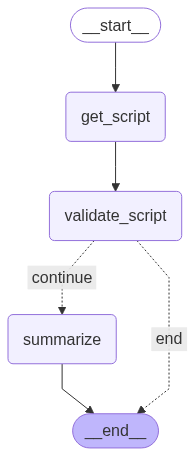

In [13]:
script_agent

In [14]:
if __name__ == "__main__":
    YOUTUBE_URL = "https://youtu.be/U6nnxml9GRs?si=Fq3hZImCCfBkbQZR"

    print("진행현황")
    
    initial_input = {"messages": [{"role": "user", "content": YOUTUBE_URL}]}
    final_state = script_agent.invoke(initial_input)
    final_summary = final_state.get('summary', '요약 결과가 없습니다.')

    print("\n\n--최종 요약 결과--")
    print(final_summary)


진행현황
1. 자막 추출
Script 가져오기 성공
2. 스크립트 유효성 검증
유효성 검증 통과
4. 최종 요약 생성
최종 요약 생성 성공


--최종 요약 결과--
안녕하세요! 이번 영상에서는 웅산이 전신을 시원하게 풀어주는 원 외각 운동을 소개합니다. 이 운동은 다른 운동 전 몸을 풀어 부상의 위험을 줄이고 운동 효율을 높여줍니다.

**운동 루틴 요약:**

1. **어깨 스트레칭**  
   - **타겟 부위:** 어깨  
   - 팔을 크게 돌리며 어깨를 풀어줍니다.

2. **가슴 스트레칭**  
   - **타겟 부위:** 가슴  
   - 팔꿈치를 뒤로 젖히며 가슴을 열어줍니다.

3. **등 스트레칭**  
   - **타겟 부위:** 등  
   - 팔을 위로 뻗고 양옆으로 늘립니다.

4. **몸통 트위스트**  
   - **타겟 부위:** 몸통  
   - 상체를 비틀어 몸통을 스트레칭합니다.

5. **하체 스트레칭 (와이드 스쿼트)**  
   - **타겟 부위:** 허벅지 안쪽, 옆구리, 어깨  
   - 다리를 넓게 벌리고 앉으며 스트레칭합니다.

6. **허벅지 뒤쪽 스트레칭**  
   - **타겟 부위:** 허벅지 뒤쪽, 옆구리  
   - 상체를 숙이고 다리를 번갈아 스트레칭합니다.

7. **발목 및 손목 스트레칭**  
   - **타겟 부위:** 손목, 발목  
   - 손목과 발목을 가볍게 돌려줍니다.

8. **점핑 10회**  
   - **타겟 부위:** 전신  
   - 마지막으로 점핑으로 심박수를 올립니다.

이 루틴을 통해 몸을 충분히 풀어주고 준비 운동을 마무리하면 운동 효율이 높아집니다. 운동 전에 잊지 말고 이 루틴을 꼭 해보세요!
